In [73]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt

from de.controller.koreainvestment_controller import get_ki_broker
from de.controller.koreainvestment_controller import ORDER_CONTROLLER

from de.processor.fdr import FDR_OHLCV_PREPROCESSOR
from de.loader.pykrx_loader import get_pykrx_loader
from de.processor.factor.trader import TRADER_FACTOR_PROCESSOR

import warnings

warnings.filterwarnings(action="ignore")
plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False

In [97]:

ki_broker = get_ki_broker()

order_controller = ORDER_CONTROLLER(ki_broker)

order_preprocessor = order_controller.order_preprocessor()
order_requester = order_controller.order_requester()

In [98]:
position_df = order_preprocessor.get_position_df()
position_df

,StockCode,StockName,BuyingPrice,CurrentPrice,Quantity
1,047050,포스코인터내셔널,58200,58100,1
2,221980,케이디켐,12220,12140,4


In [99]:
StockName_dict = position_df.set_index("StockCode")["StockName"].to_dict()

In [100]:
start = (dt.date.today() - dt.timedelta(days=10)).strftime("%Y-%m-%d")
end = (dt.date.today() - dt.timedelta(days=1)).strftime("%Y-%m-%d")

In [105]:
pykrx_loader = get_pykrx_loader()

trader_df_list = list()
for stockcode in set(position_df["StockCode"]):
    trader_df = pykrx_loader.get_stock_trader_df(StockCode=stockcode, start=start, end=end)
    trader_df["StockCode"] = stockcode
    trader_df_list.append(trader_df)

trader_df = pd.concat(trader_df_list)

In [108]:
format_dict = {
    "Corp": ["금융투자", "보험", "투신", "사모"],
    "Indivisual": ["개인"],
    "Foreign": ["외국인"],
}
for key, value in format_dict.items():
    trader_df[key] = trader_df.loc[:, value].sum(axis=1)
pps_trader_df = trader_df.loc[:, list(format_dict.keys()) + ["StockCode"]]

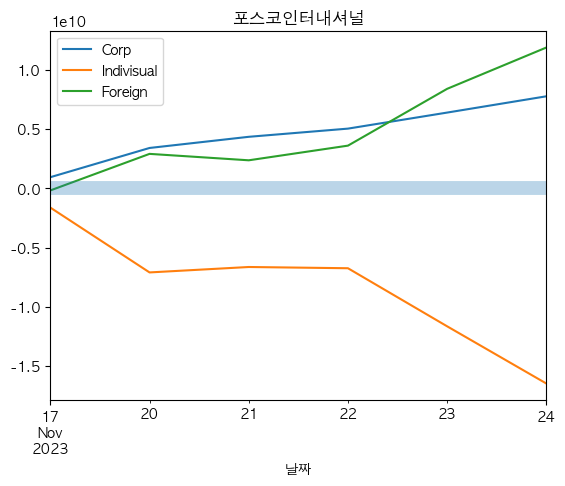

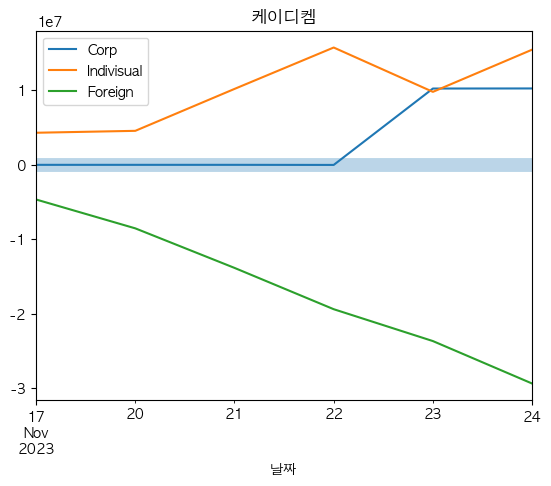

In [109]:
for stockcode in set(pps_trader_df["StockCode"]):
    pps_trader_df[pps_trader_df["StockCode"] == stockcode].tail(14).cumsum().plot()
    plt.axhline(0, linewidth=10, alpha=0.3)
    plt.title(StockName_dict[stockcode])
    plt.show()

In [110]:
# fdr_ohlcv
fdr_ohlcv_df = pd.read_csv("./de/data/fdr_ohlcv_df.csv", index_col=0)
fdr_ohlcv_preprocessor = FDR_OHLCV_PREPROCESSOR(fdr_ohlcv_df)
ohlcv_df = fdr_ohlcv_preprocessor.get_pps_fdr_ohlcv_df()

In [111]:
BuyingPrice_dict = position_df.set_index("StockCode")["BuyingPrice"].to_dict()

In [112]:
stockcode=list(set(position_df["StockCode"]))[0]

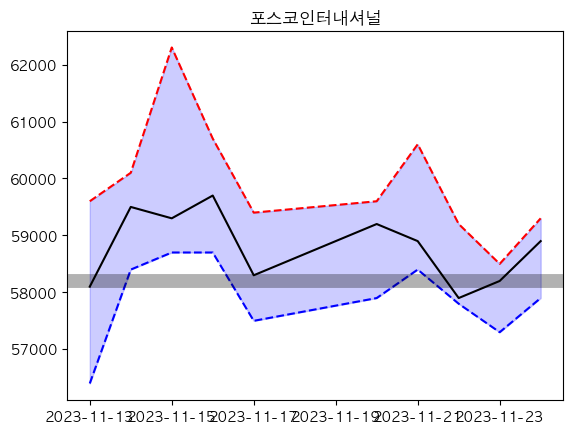

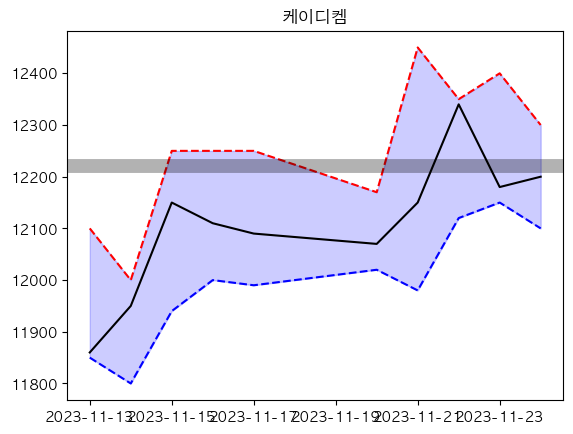

In [114]:
for stockcode in set(pps_trader_df["StockCode"]):
    _df = ohlcv_df[ohlcv_df["StockCode"] == stockcode].tail(10).copy()
    plt.plot(_df["Date"], _df["Close"], label="Close", color="k")
    plt.fill_between(_df["Date"], _df["Low"], _df["High"], color="blue", alpha=0.2)
    plt.plot(_df["Date"], _df["Low"], label="Lowe", linestyle="--", color="b")
    plt.plot(_df["Date"], _df["High"], label="High", linestyle="--", color="r")
    plt.axhline(BuyingPrice_dict[stockcode], linewidth=10, alpha=0.3, color="k")
    plt.title(StockName_dict[stockcode])
    plt.show()